# Detecting Covid-19 from Chest X-Rays

Train a classification model on chest x-ray images of individuals with covid-19 and those without.

[Dataset source](https://www.kaggle.com/datasets/alifrahman/covid19-chest-xray-image-dataset/)

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [66]:
# import necessary packages
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# set seed
torch.manual_seed(123)
np.random.seed(123)
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
print(torch.version.cuda)

Using device cuda
11.7


## Loading Data

In [20]:
# Calculating mean and standard deviation for normalization step

data_dir = 'data/xray-dataset'
batch_size = 10


transform=transforms.Compose([transforms.Resize(256),
                             transforms.CenterCrop(224),
                             transforms.ToTensor()])
dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform)

loader = DataLoader(dataset,
                    batch_size=batch_size,
                    shuffle=True)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*224*224))
print(mean, std)

tensor([0.5387, 0.5406, 0.5427]) tensor([0.1972, 0.1970, 0.1972])


In [35]:
transform_norm = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])
normalized_dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform_norm)
data_loader = DataLoader(normalized_dataset,
                    batch_size=batch_size,
                    shuffle=True)

## Visualizing Images

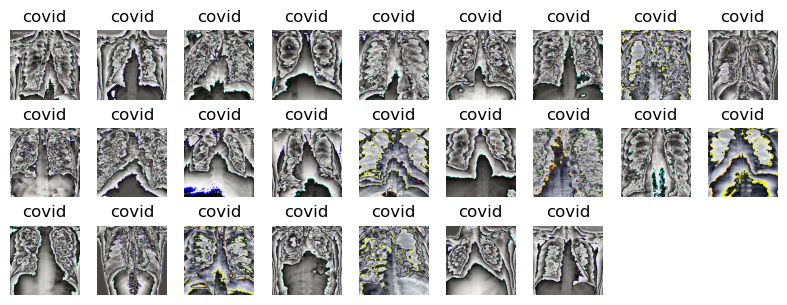

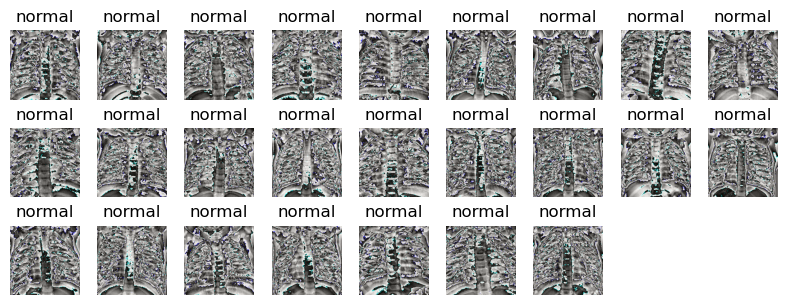

In [65]:
import os
covid_files = [data_dir+'/covid/'+f for f in os.listdir(data_dir+'/covid/')]
normal_files = [data_dir+'/normal/'+f for f in os.listdir(data_dir+'/normal/')]

# List of file paths to plt plot
# optionally provide label (same across all files)
# optionally provide number of random samples to show at a time
def show_images(data_files, label=None, maxShow=None):
    if maxShow is not None and maxShow < len(data_files):
        data_files = np.random.choice(data_files, size=maxShow, replace=False)
    fig = plt.figure(figsize=(8, 8))
    for i, f in enumerate(data_files):
        ax = plt.subplot(8, 9, i+1)
        img_tr = transform_norm(Image.open(f).convert('RGB'))
        img_np = np.array(img_tr)
        img = img_np.transpose(1, 2, 0)
        img = (img*255.0).astype("uint8")
        plt.imshow(img)
        if label:
            plt.title(label)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_images(covid_files, "covid", len(normal_files))
show_images(normal_files, "normal")

## Training

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4,6)
        self.fc2 = nn.Linear(6,6)                                   
        self.out = nn.Linear(6, 3)      
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x